Load Libraries

In [1]:
#### Dependencies ####
####
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
#from manim import *
from scipy.io import wavfile as wav
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf
import os
import warnings

### Loading audios with librosa

In [2]:
def load_audios(BASE_FOLDER,sr):
  files = os.listdir(BASE_FOLDER)
  raw_audio = []
  labels = []
  for f in files:
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      audio, _ = librosa.load(os.path.join(BASE_FOLDER, f),sr=sr, offset=0.2, duration=5)
      #audio, _ = librosa.load(os.path.join(BASE_FOLDER, f),sr=sr)
    raw_audio.append(audio)
    name = f.split(".")[0]
    labels.append(int(name.split("-")[1]))
  return raw_audio,labels

In [3]:
BASE_FOLDER1="Dataset/matchbox"
BASE_FOLDER2="Dataset/original"
sr = 44100
raw_audio,labels = load_audios(BASE_FOLDER1,sr)
raw_audio2,labels2 = load_audios(BASE_FOLDER2,sr)
raw_audio = raw_audio + raw_audio2
labels = labels + labels2

Initial visualization of data

In [4]:
def plot_magnitude_spectrum(signal, sr, title, f_ratio=1):
    X = np.fft.fft(signal)
    X_mag = np.absolute(X)

    plt.figure(figsize=(18, 5))

    f = np.linspace(0, sr, len(X_mag))
    f_bins = int(len(X_mag)*f_ratio)
    print(len(X_mag))
    print(f_bins)
    plt.plot(f[:f_bins], X_mag[:f_bins])
    plt.xlabel('Frequency (Hz)')
    plt.title(title)

In [5]:
BASE_FOLDER = BASE_FOLDER1

220500
73500


Text(0.5, 1.0, 'Signal')

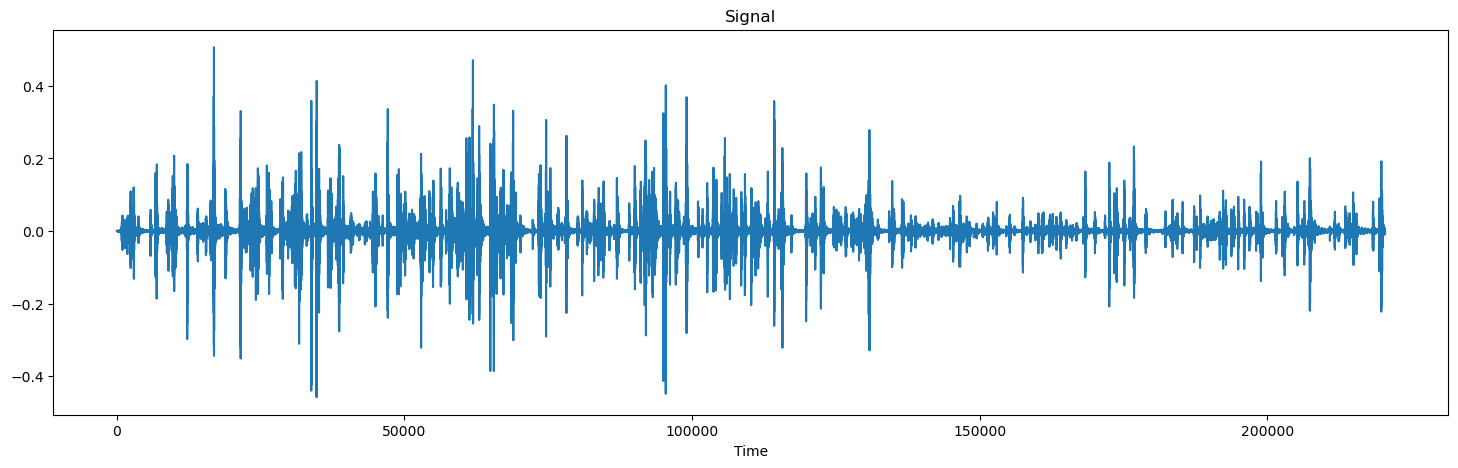

<Figure size 1800x500 with 0 Axes>

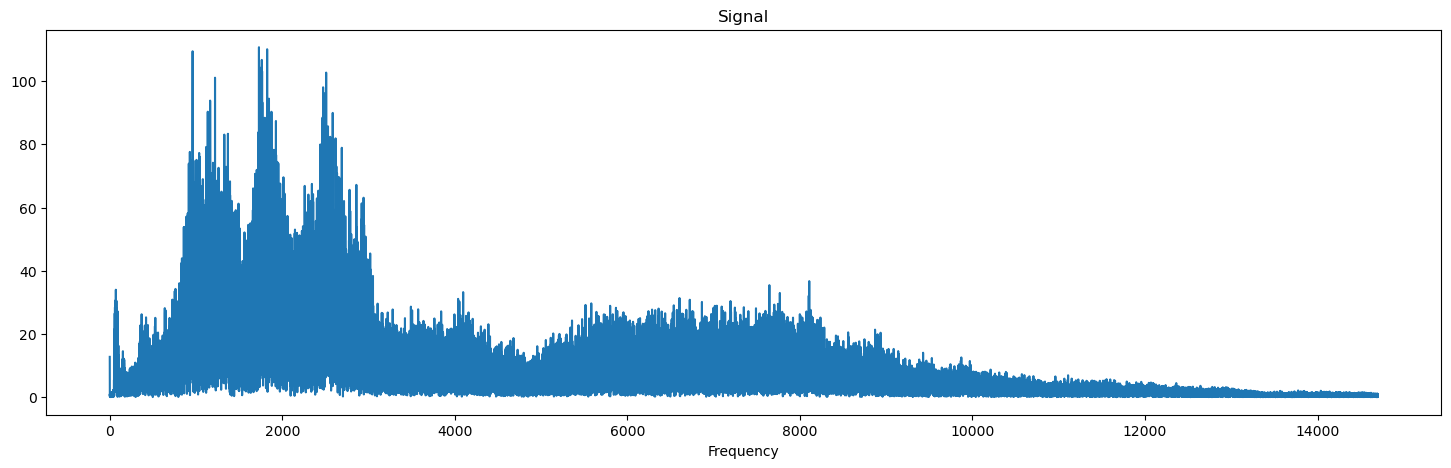

In [6]:
plt.figure(num=1,figsize=(18, 5))
plt.plot(raw_audio[0])
plt.xlabel('Time')
plt.title("Signal")

plt.figure(num=2,figsize=(18, 5))
plot_magnitude_spectrum(raw_audio[0], sr, "Audio ejemplo", 1/3)
plt.xlabel('Frequency')
plt.title("Signal")

Obtain FFT and MFCC for an array of audios

In [7]:
def obtain_fft_mfcc(raw_audio):
  mfccs_processed = []
  ffts_mag = []
  len_fft = 85000
  for i in raw_audio:
    X = np.fft.fft(i)
    ffts_mag.append(np.absolute(X[:len_fft]))
    mfccs = librosa.feature.mfcc(y=i, sr=sr, n_mfcc=40)
    mfccs_processed.append(np.mean(mfccs.T,axis=0))
  return ffts_mag,mfccs_processed

In [8]:
ffts_mag,mfccs_processed = obtain_fft_mfcc(raw_audio)

Create a dataframe with all the data


In [9]:
df = pd.DataFrame(list(zip(raw_audio, ffts_mag, mfccs_processed, labels)),
               columns =['Raw_Audio', 'FFT', "MFCC", "Number_Matches"])

In [10]:
df.head()

,Raw_Audio,FFT,MFCC,Number_Matches
0,"[0.00019836426, 0.00019836426, 0.00019836426, ...","[12.773574829101562, 1.6305854215990774, 0.692...","[-320.3268, 116.20466, -105.377335, 22.920633,...",1
1,"[0.00019836426, 0.00019836426, 0.00021362305, ...","[9.064697265625, 0.8087828525911769, 1.4386248...","[-351.7072, 125.50488, -110.67668, 2.240221, -...",1
2,"[0.002105713, 0.0036773682, 0.0037231445, 0.00...","[10.047607421875, 1.8584604597480519, 0.424037...","[-356.7968, 120.296425, -110.80395, 7.715751, ...",1
3,"[-0.00012207031, -0.0001373291, -0.00012207031...","[9.905364990234375, 0.7286603023429552, 0.4653...","[-322.42734, 130.28204, -110.72155, 1.4568917,...",1
4,"[-0.0005340576, -0.0005340576, -0.00050354004,...","[9.03887939453125, 0.16227949459898, 0.5772629...","[-355.0172, 133.23697, -105.7715, 0.54188246, ...",1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Raw_Audio       2050 non-null   object
 1   FFT             2050 non-null   object
 2   MFCC            2050 non-null   object
 3   Number_Matches  2050 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 64.2+ KB


Define the input and labels


In [12]:
X = np.array(df.MFCC.tolist())
y = np.array(df.Number_Matches.tolist())

In [13]:
np.shape(X)

(2050, 40)

In [14]:
seed = np.random.seed(20) #Make reproducible

Split the data for training and testing

In [15]:
#@title
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify=y)

In [16]:
#@title
y_test

array([  8,  35,   3,   4, 120, 100, 120,   8,  80,  60,   5, 100,  18,
        13,  19,  14,  65,  13,  45,   6,  70,  26,   2,  30,  70,  50,
       130,  18,  17,  30,  26,  15,   7,   6,  35,  65,  10,   6,  14,
        30,  50,  14,  40,   9,  55,  22,  14, 150,  26,  17,  14,  90,
        19,   5,   4,  26,  55,  16,  80, 120,  70, 120,   7, 110, 150,
       130, 140,   6,  45,  70,   9,  10,  65,  15,  50,  60,  24,   2,
        16,  11,   7,  40, 140,  15,  90,   9,   4,  24, 110,  28,  20,
        80,  18,  26,  19,   8,   1,  30,  22,  14,   7,   1,  17,  24,
        19,  40,  80,  11,  28,  11,  18,  11,  16, 130,  18,  19,  16,
        26,   5,   2, 150, 110,  15,  90,  80,  65,   3,   3,  20,  16,
       100,  70,   1,  90,  40,  11,  22, 130,  26,   5,  55,   7,  28,
        16, 140,  35,  12,  22,  24,  90,  12, 100,  60,  50,   5,  24,
       140,  70,  20,   7,  16,   8,   1,  45,   4,  60,  19, 130,  28,
        90,  10,  17,   3,   6, 100,  10,  26,  45,  10,  10,  6

DNN Model

In [17]:
def build_model_MFCC():
  model = tf.keras.Sequential([
                             tf.keras.layers.Dense(40, activation='relu', input_shape=[x_train.shape[1]]),
                             tf.keras.layers.Dense(20, activation='relu'),
                             tf.keras.layers.Dropout((0.2)),
                             tf.keras.layers.Dense(10, activation='relu'),
                             tf.keras.layers.Dense(1)])


  # Choose the preference optimizer.
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  #Select the loss function (MSE)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model_MFCC = build_model_MFCC();
model_MFCC.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                1640      
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2681 (10.47 KB)
Trainable params: 2681 (10.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train the model

In [18]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Models/model_MFCC3.hdf5', verbose=1, save_best_only=True)
#earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [19]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime
num_epochs = 200
num_batch_size = 32
history_model_MFCC = model_MFCC.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, callbacks=[checkpointer], validation_data=(x_test, y_test), verbose=1)

Epoch 1/200


50/52 [===========================>..] - ETA: 0s - loss: 2111.4998 - mae: 34.1538 - mse: 2111.4998
Epoch 1: val_loss improved from inf to 1729.55188, saving model to Models\model_MFCC3.hdf5
52/52 [==============================] - 2s 10ms/step - loss: 2121.7944 - mae: 34.2471 - mse: 2121.7944 - val_loss: 1729.5519 - val_mae: 33.2673 - val_mse: 1729.5519
Epoch 2/200
45/52 [========================>.....] - ETA: 0s - loss: 1801.3932 - mae: 33.0710 - mse: 1801.3932

c:\Users\gugu1\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1729.55188 to 1615.41284, saving model to Models\model_MFCC3.hdf5
52/52 [==============================] - 0s 4ms/step - loss: 1806.7622 - mae: 33.2699 - mse: 1806.7622 - val_loss: 1615.4128 - val_mae: 32.9880 - val_mse: 1615.4128
Epoch 3/200
28/52 [===============>..............] - ETA: 0s - loss: 1769.5292 - mae: 32.5147 - mse: 1769.5292
Epoch 3: val_loss improved from 1615.41284 to 1466.12744, saving model to Models\model_MFCC3.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 1709.0302 - mae: 32.0215 - mse: 1709.0302 - val_loss: 1466.1274 - val_mae: 29.9584 - val_mse: 1466.1274
Epoch 4/200
25/52 [=============>................] - ETA: 0s - loss: 1542.3080 - mae: 30.3698 - mse: 1542.3080
Epoch 4: val_loss improved from 1466.12744 to 1240.48706, saving model to Models\model_MFCC3.hdf5
52/52 [==============================] - 0s 3ms/step - loss: 1497.1710 - mae: 29.2729 - mse: 1497.1710 - val_loss: 1240.4871 - val_mae: 28.1007 - val_mse

Results of accuracy

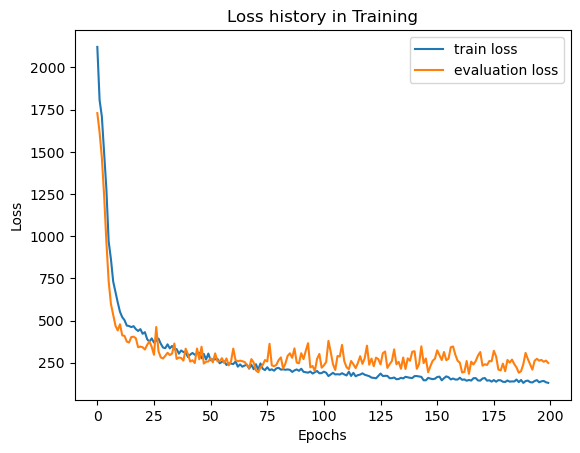

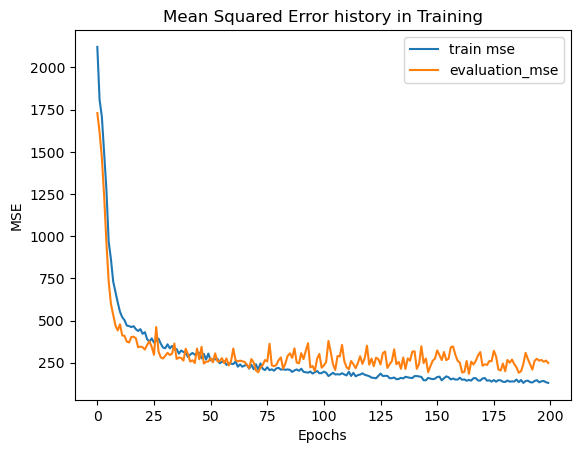

In [20]:
plt.plot(history_model_MFCC.history['loss'], label='train loss');
plt.plot(history_model_MFCC.history['val_loss'], label='evaluation loss');
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss history in Training")
plt.legend()
plt.show();

plt.plot(history_model_MFCC.history['mse'], label='train mse');
plt.plot(history_model_MFCC.history['val_mse'], label='evaluation_mse');
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Mean Squared Error history in Training")
plt.legend()
plt.show()

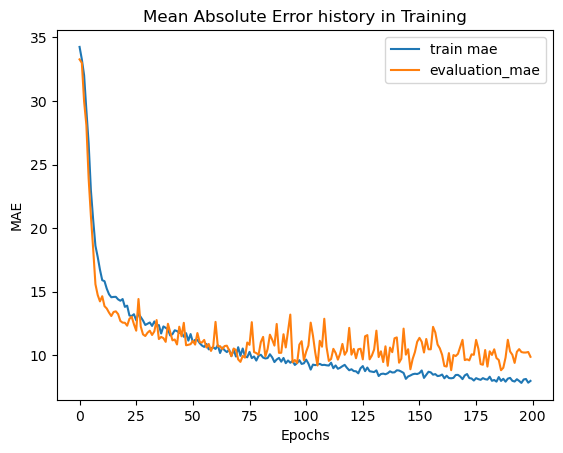

In [21]:
plt.plot(history_model_MFCC.history['mae'], label='train mae');
plt.plot(history_model_MFCC.history['val_mae'], label='evaluation_mae');
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Mean Absolute Error history in Training")
plt.legend()
plt.show()

In [22]:
loss, mae, mse = model_MFCC.evaluate(x_test, y_test)
loss, mae, mse

13/13 [==============================] - 0s 1ms/step - loss: 248.8876 - mae: 9.8810 - mse: 248.8876


(248.8876495361328, 9.880977630615234, 248.8876495361328)

In [23]:
#@title
result = model_MFCC.predict(np.reshape(x_test[0],[1,40]))
int(result[0])

1/1 [==============================] - 0s 142ms/step


7

In [24]:
#@title
result = model_MFCC.predict(x_test[0:30])
result

1/1 [==============================] - 0s 47ms/step


array([[ 7.4247894 ],
       [31.543812  ],
       [ 2.6843836 ],
       [ 3.1446555 ],
       [87.23148   ],
       [92.21148   ],
       [70.93817   ],
       [10.553089  ],
       [60.773148  ],
       [51.568886  ],
       [ 0.98923135],
       [78.94495   ],
       [49.092747  ],
       [11.687477  ],
       [14.186881  ],
       [10.594443  ],
       [64.1477    ],
       [15.062819  ],
       [33.282932  ],
       [ 6.508848  ],
       [75.7333    ],
       [19.66436   ],
       [ 3.1012442 ],
       [36.49811   ],
       [68.05964   ],
       [68.68383   ],
       [94.89147   ],
       [17.406376  ],
       [14.127314  ],
       [18.768053  ]], dtype=float32)

In [25]:
#@title
y_test[:30]

array([  8,  35,   3,   4, 120, 100, 120,   8,  80,  60,   5, 100,  18,
        13,  19,  14,  65,  13,  45,   6,  70,  26,   2,  30,  70,  50,
       130,  18,  17,  30])

Load DNN model

In [26]:
model_loaded = tf.keras.models.load_model('Models/model_MFCC3.hdf5')

Results of precision

In [27]:
loss, mae, mse = model_loaded.evaluate(x_test, y_test)
loss, mae, mse

13/13 [==============================] - 0s 2ms/step - loss: 184.5129 - mae: 8.8274 - mse: 184.5129


(184.5128936767578, 8.827445030212402, 184.5128936767578)

In [28]:
#@title
result = model_loaded.predict(np.reshape(x_test[0],[1,40]))
int(result[0])

1/1 [==============================] - 0s 71ms/step


7

In [29]:
#@title
result = model_loaded.predict(x_test[0:30])
print((np.rint(result)).astype(int))

1/1 [==============================] - 0s 23ms/step
[[  7]
 [ 33]
 [  2]
 [  4]
 [ 98]
 [103]
 [ 77]
 [  9]
 [ 64]
 [ 59]
 [  0]
 [ 86]
 [ 60]
 [ 13]
 [ 14]
 [ 12]
 [ 68]
 [ 15]
 [ 39]
 [  8]
 [ 83]
 [ 21]
 [  4]
 [ 42]
 [ 81]
 [ 76]
 [102]
 [ 19]
 [ 15]
 [ 19]]


In [30]:
#@title
y_test[:30]

array([  8,  35,   3,   4, 120, 100, 120,   8,  80,  60,   5, 100,  18,
        13,  19,  14,  65,  13,  45,   6,  70,  26,   2,  30,  70,  50,
       130,  18,  17,  30])

In [31]:
def moving_window(y_test, y_pred, size):
  idx_sort = np.argsort(y_test)
  y_test = y_test[idx_sort]
  y_pred = y_pred[idx_sort]
  mov_test = []
  mov_pred = []
  for i in range(len(y_test) - (size-1)):
    mov_test.append(y_test[i:i+size])
    mov_pred.append(y_pred[i:i+size])
  return mov_test,mov_pred

In [32]:
def local_MSE(yg_test,yg_pred):
  l_MSE = []
  for idx, m_t in enumerate(yg_test):
    l_MSE.append(mean_squared_error(m_t,yg_pred[idx]))
  return np.array(l_MSE)

def local_MAE(yg_test,yg_pred):
  l_MSE = []
  for idx, m_t in enumerate(yg_test):
    l_MSE.append(mean_absolute_error(m_t,yg_pred[idx]))
  return np.array(l_MSE)


In [33]:
def own_grouping(y_test, y_pred, o_sz_group, sz_split, grouping):
  idx_sort = np.argsort(y_test)
  y_test = y_test[idx_sort]
  y_pred = y_pred[idx_sort]
  yg_test = []
  yg_pred = []
  size_group = int(o_sz_group*sz_split)
  idx_prev = 0
  for i in grouping:
    idx_n = i*size_group
    yg_test.append(y_test[idx_prev:idx_n])
    yg_pred.append(y_pred[idx_prev:idx_n])
    idx_prev = idx_n
  return yg_test,yg_pred

In [34]:
def moving_window_average(array,size):
  #idx_sort = np.argsort(array)
  #array = array[idx_sort]
  mov_avg_array = []
  for i in range(len(array) - (size-1)):
    #print(array[i:i+size])
    mov_avg_array.append(np.mean(array[i:i+size]))

  return mov_avg_array

In [35]:
result = model_loaded.predict(x_test)

13/13 [==============================] - 0s 2ms/step


In [36]:
grouping = [20, 25, 33, 41]
ygo_test,ygo_pred = own_grouping(y_test, result, 25, 0.2, grouping)

Text(0.5, 1.0, 'Grouped RMSE by increment')

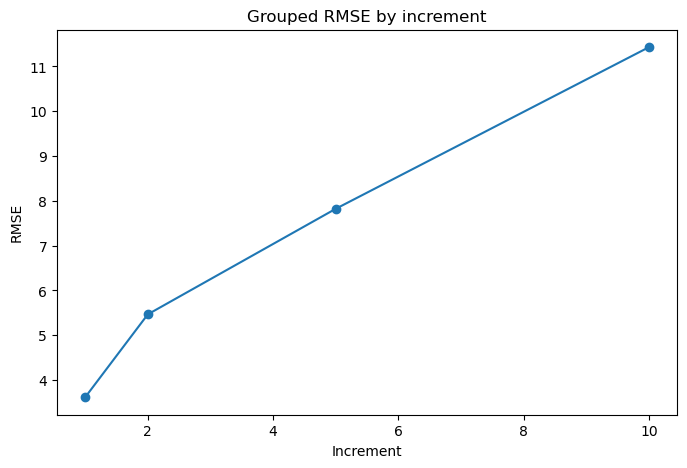

In [37]:
grouped_MSE = local_MSE(ygo_test,ygo_pred)
grouped_RMSE = np.sqrt(grouped_MSE)
increments = [1, 2, 5, 10]
plt.figure(num=1,figsize=(8, 5))
plt.plot(increments,grouped_RMSE, '-o')
plt.xlabel("Increment")
plt.ylabel("RMSE")
plt.title("Grouped RMSE by increment")

Text(0.5, 1.0, 'Grouped MAE by increment')

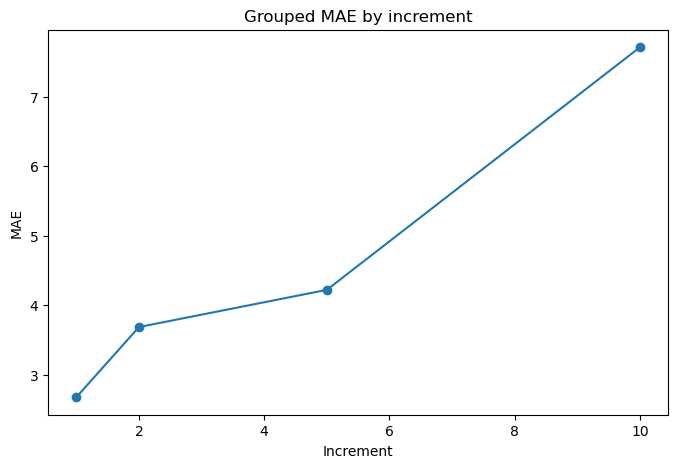

In [38]:
grouped_MAE = local_MAE(ygo_test,ygo_pred)
plt.figure(num=1,figsize=(8, 5))
increments = [1, 2, 5, 10]
plt.plot(increments,grouped_MAE, '-o')
plt.xlabel("Increment")
plt.ylabel("MAE")
plt.title("Grouped MAE by increment")

In [52]:
def own_grouping2(y_test, y_pred, o_sz_group, sz_split):
  idx_sort = np.argsort(y_test)
  y_test = y_test[idx_sort]
  y_pred = y_pred[idx_sort]
  yg_test = []
  yg_pred = []
  size_group = int(o_sz_group*sz_split)
  idx_prev = 0
  for i in range(size_group,len(y_test)+1,size_group):
    idx_n = i
    yg_test.append(y_test[idx_prev:idx_n])
    yg_pred.append(y_pred[idx_prev:idx_n])
    idx_prev = idx_n
  return yg_test,yg_pred

In [53]:
ygo_test2,ygo_pred2 = own_grouping2(y_test, result, 50, 0.2)

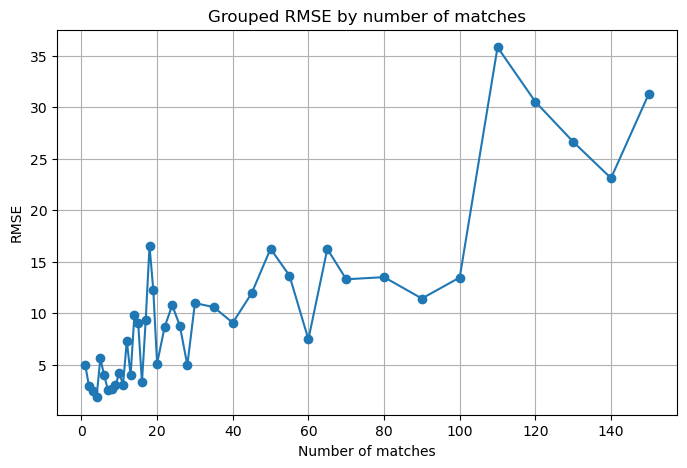

In [63]:
grouped_MSE2 = local_MSE(ygo_test2,ygo_pred2)
grouped_RMSE2 = np.sqrt(grouped_MSE2)
x=np.concatenate([np.arange(1,21,1),np.arange(22,31,2),np.arange(35,71,5),np.arange(80,151,10)])
plt.figure(num=1,figsize=(8, 5))
plt.plot(x,grouped_RMSE2, '-o')
plt.xlabel("Number of matches")
plt.ylabel("RMSE")
plt.title("Grouped RMSE by number of matches")
plt.grid()

In [64]:
grouped_RMSE2

array([ 5.01578419,  2.90573089,  2.4156163 ,  1.85438806,  5.62825067,
        3.99258024,  2.55772491,  2.63911569,  3.00459934,  4.20714606,
        3.07309076,  7.35000552,  3.96551465,  9.81529784,  9.06201656,
        3.29336293,  9.37410512, 16.53178286, 12.24440475,  5.1136407 ,
        8.67708515, 10.78241559,  8.80408101,  4.97028742, 10.98714631,
       10.59286495,  9.0765445 , 11.94101637, 16.25733602, 13.64593626,
        7.4705584 , 16.23772254, 13.29546477, 13.50390455, 11.43069203,
       13.4682537 , 35.80735706, 30.51588806, 26.62938076, 23.10511484,
       31.29484909])

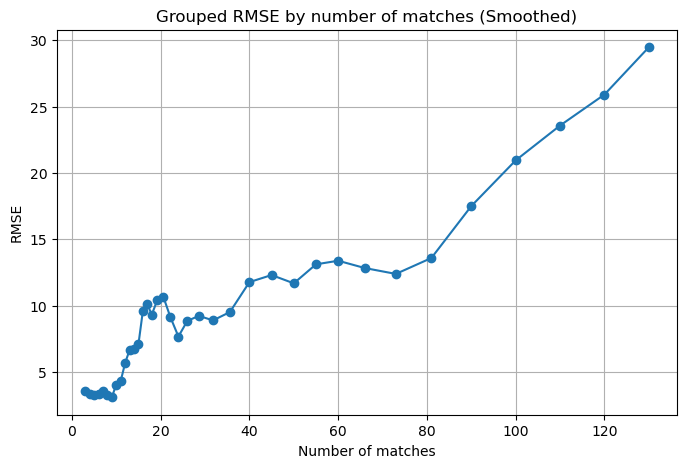

In [65]:
size=5
moving_RMSE2 = moving_window_average(grouped_RMSE2,size)
x=moving_window_average(np.concatenate([np.arange(1,21,1),np.arange(22,31,2),np.arange(35,71,5),np.arange(80,151,10)]),size)
plt.figure(num=1,figsize=(8, 5))
plt.plot(x,moving_RMSE2, '-o')
plt.xlabel("Number of matches")
plt.ylabel("RMSE")
plt.title("Grouped RMSE by number of matches (Smoothed)")
plt.grid()

In [66]:
grouped_MSE2 = local_MSE(ygo_test2,ygo_pred2)


In [67]:
x

[3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.2,
 20.6,
 22.2,
 24.0,
 26.0,
 28.6,
 31.8,
 35.6,
 40.0,
 45.0,
 50.0,
 55.0,
 60.0,
 66.0,
 73.0,
 81.0,
 90.0,
 100.0,
 110.0,
 120.0,
 130.0]

In [68]:
grouped_RMSE2

array([ 5.01578419,  2.90573089,  2.4156163 ,  1.85438806,  5.62825067,
        3.99258024,  2.55772491,  2.63911569,  3.00459934,  4.20714606,
        3.07309076,  7.35000552,  3.96551465,  9.81529784,  9.06201656,
        3.29336293,  9.37410512, 16.53178286, 12.24440475,  5.1136407 ,
        8.67708515, 10.78241559,  8.80408101,  4.97028742, 10.98714631,
       10.59286495,  9.0765445 , 11.94101637, 16.25733602, 13.64593626,
        7.4705584 , 16.23772254, 13.29546477, 13.50390455, 11.43069203,
       13.4682537 , 35.80735706, 30.51588806, 26.62938076, 23.10511484,
       31.29484909])

Text(0.5, 1.0, 'Grouped MAE by number of matches')

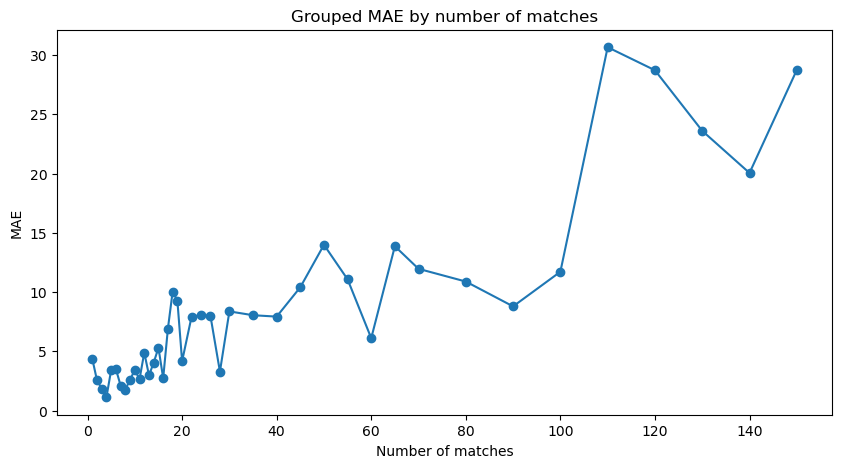

In [69]:
grouped_MAE2 = local_MAE(ygo_test2,ygo_pred2)
x=np.concatenate([np.arange(1,21,1),np.arange(22,31,2),np.arange(35,71,5),np.arange(80,151,10)])
plt.figure(num=1,figsize=(10, 5))
plt.plot(x,grouped_MAE2, '-o')
plt.xlabel("Number of matches")
plt.ylabel("MAE")
plt.title("Grouped MAE by number of matches")